In [1]:
import gym

In [61]:
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DQNCartPoleSolver():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=4, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))

        #config = self.model.get_config()
        #self.model2 = Sequential.from_config(config)
        #self.model2.compile(loss='mse', optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state))

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch, x2_batch, y2_batch = [], [], [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max( self.model.predict(next_state)[0] )
            x_batch.append(state[0])
            y_batch.append(y_target[0])

        #for state, action, reward, next_state, done in minibatch:
        #    y2_target = self.model2.predict(state)
        #    next_action = np.argmax( self.model2.predict(next_state)[0] )
        #    y2_target[0][action] = reward if done else reward + self.gamma * self.model.predict(next_state)[0][next_action]
        #    x2_batch.append(state[0])
        #    y2_batch.append(y2_target[0])
            
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #self.model2.fit(np.array(x2_batch), np.array(y2_batch), batch_size=len(x2_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e


In [62]:
agent = DQNCartPoleSolver(n_episodes=10000,batch_size=64)
agent.run()

[Episode 0] - Mean survival time over last 100 episodes was 18.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 18.85 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 39.15 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 65.61 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 80.68 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 190.59 ticks.
Ran 505 episodes. Solved after 405 trials ✔


405

In [63]:
# The typical imports
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


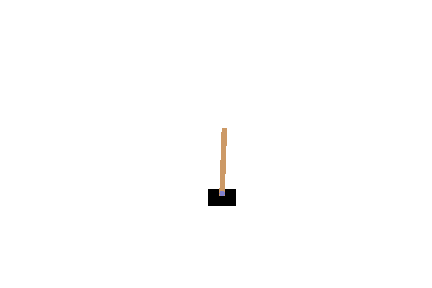
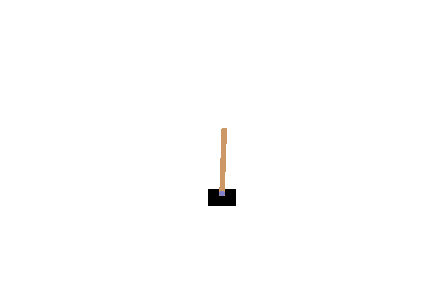
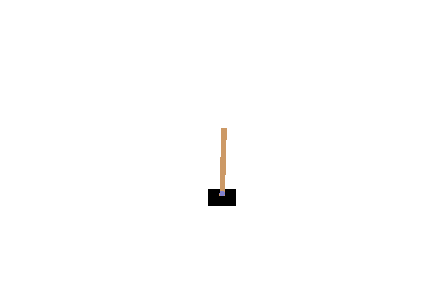
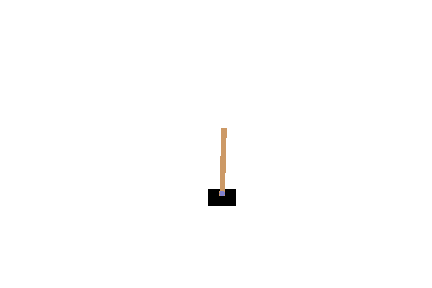
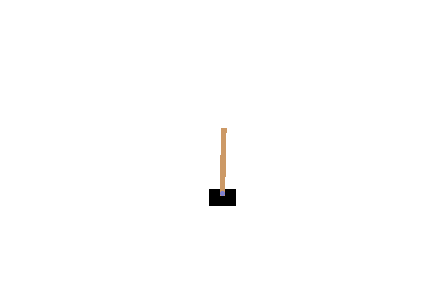
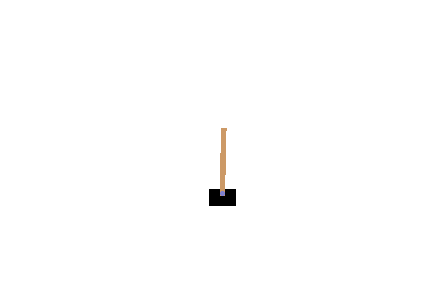
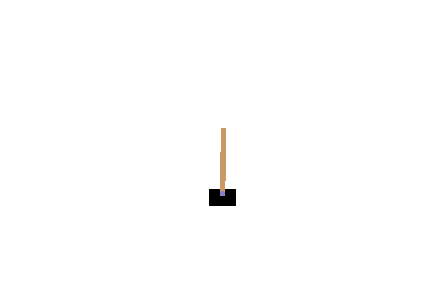
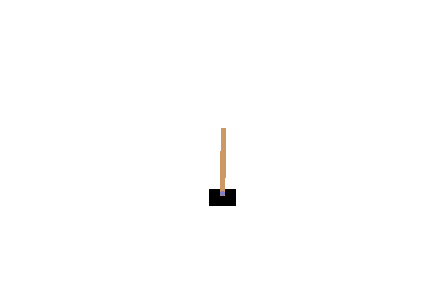
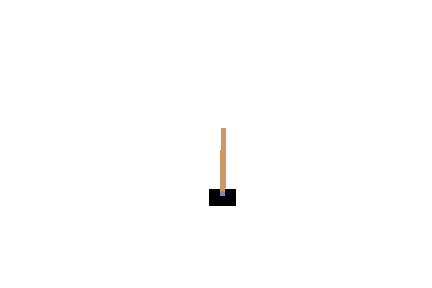
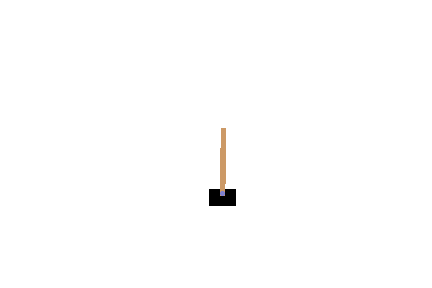
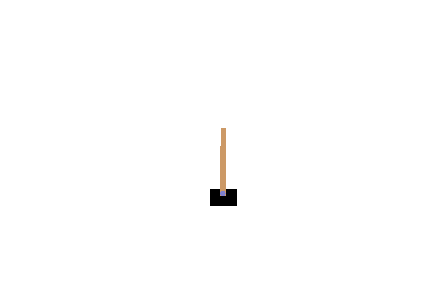
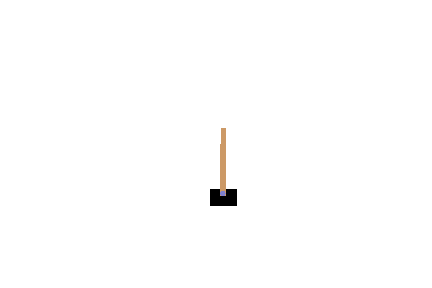
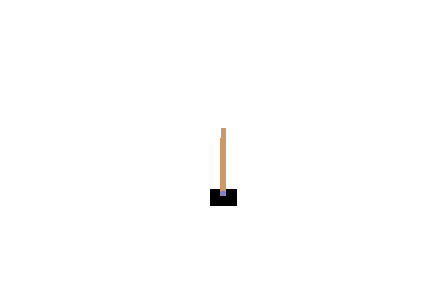
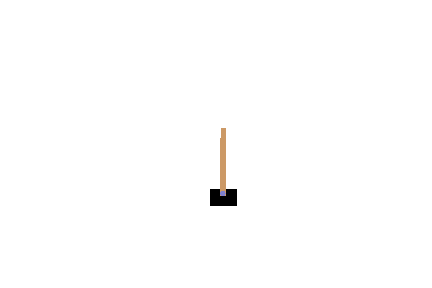
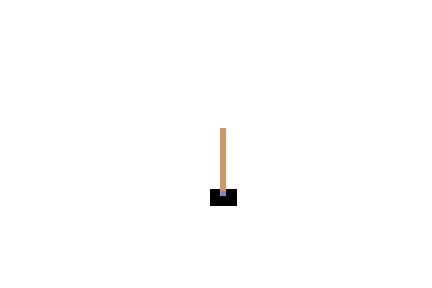
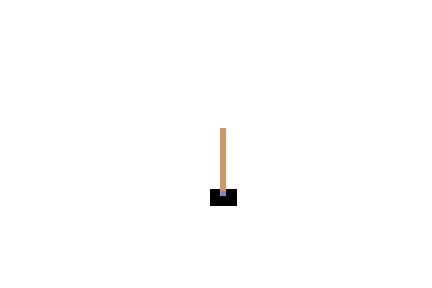
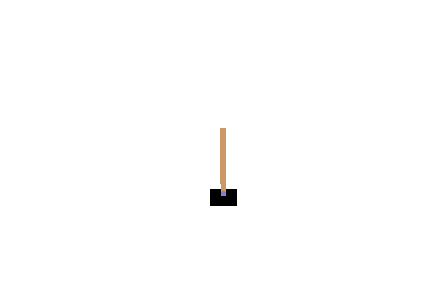
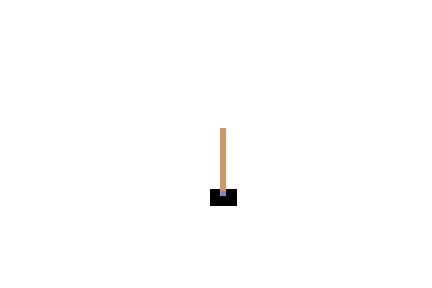
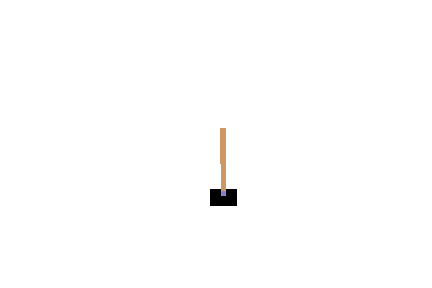
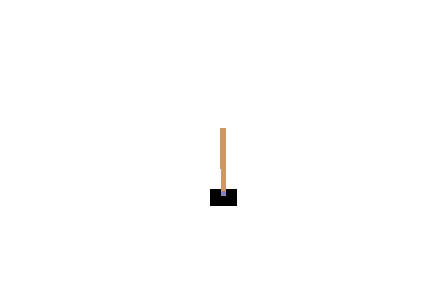
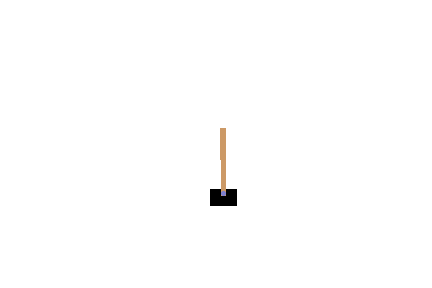
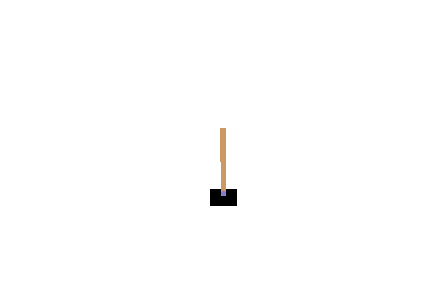
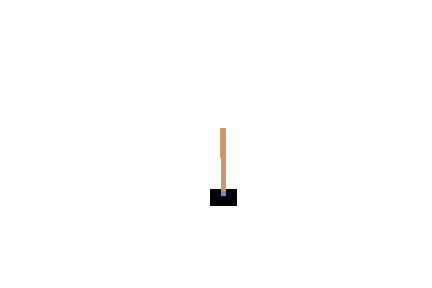
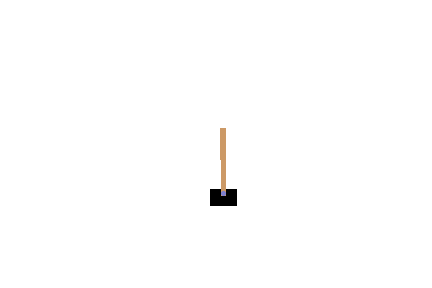
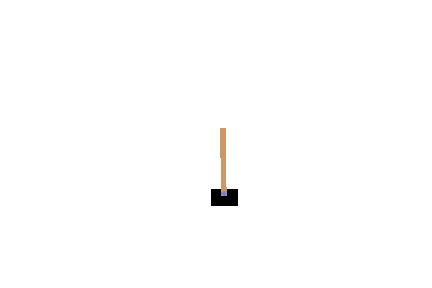
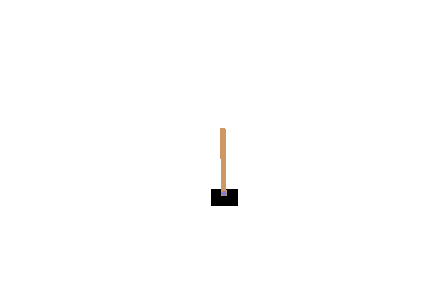
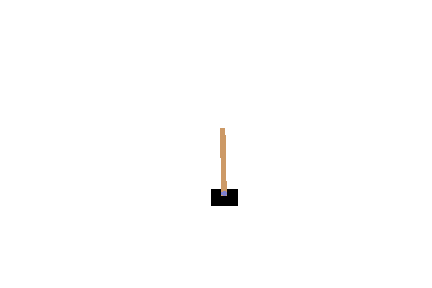
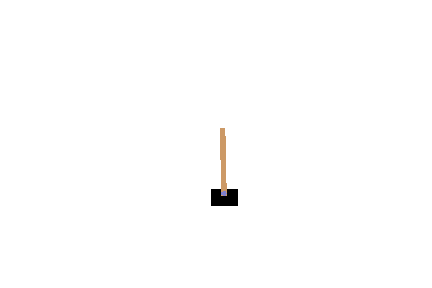
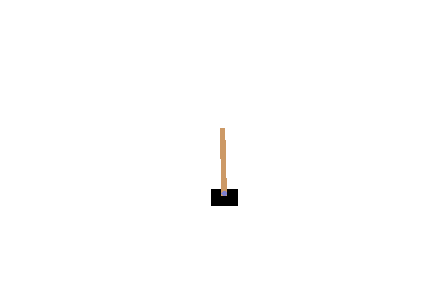
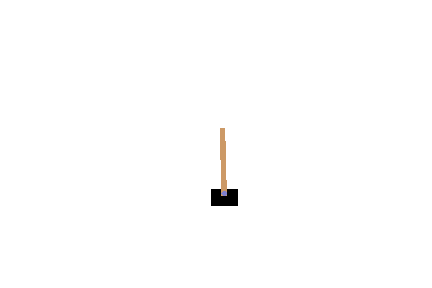
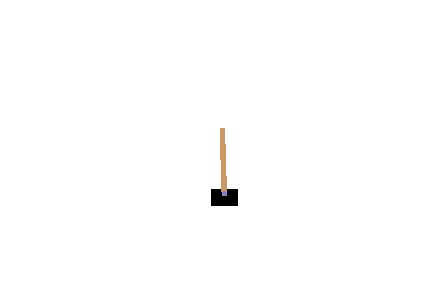
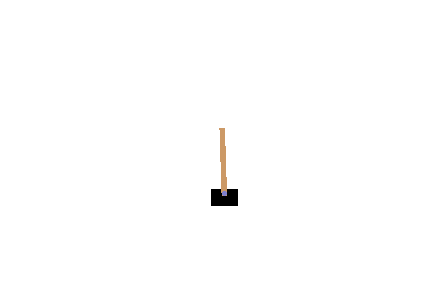
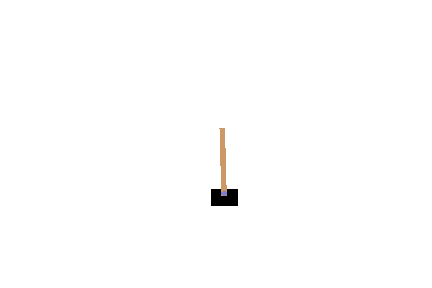
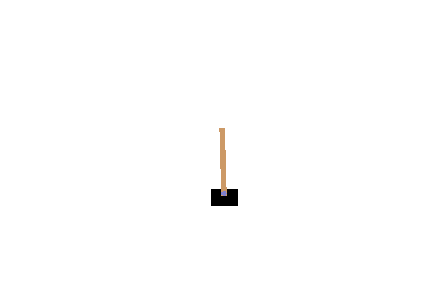
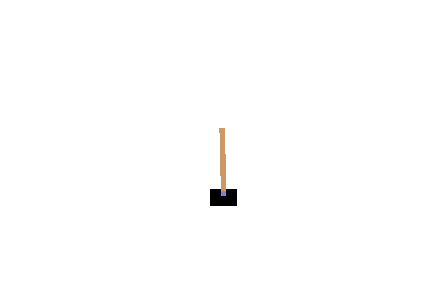
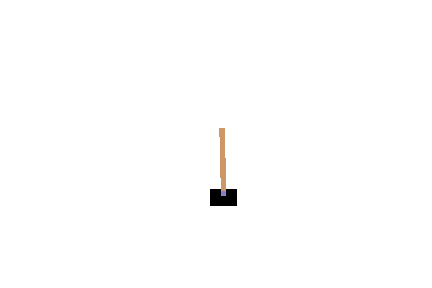
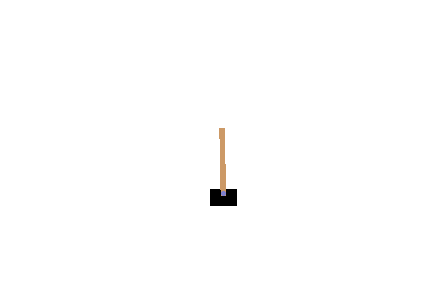
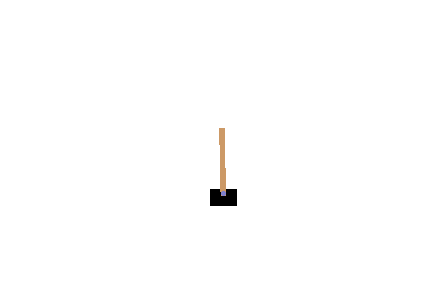
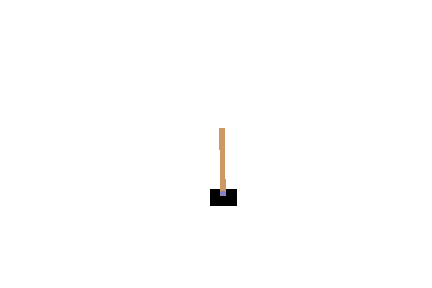
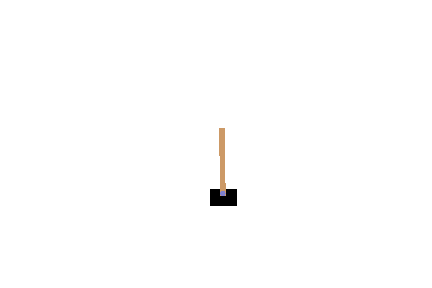
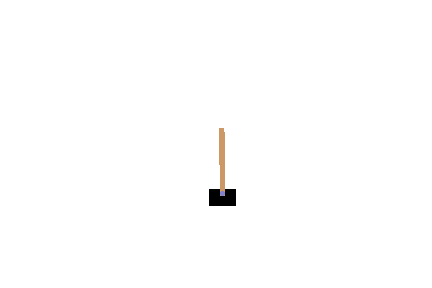
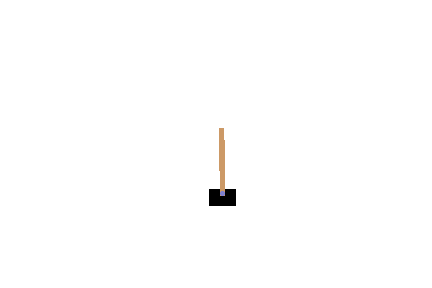
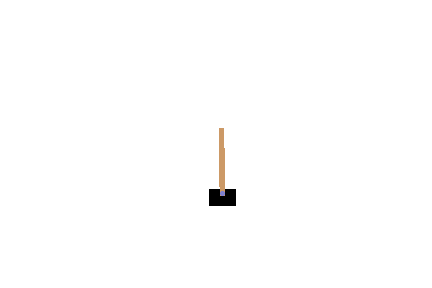
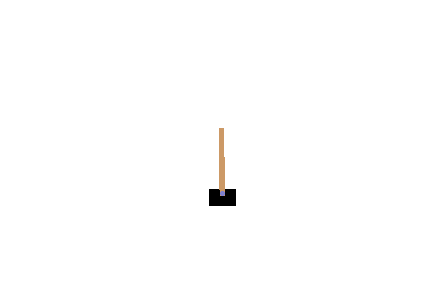
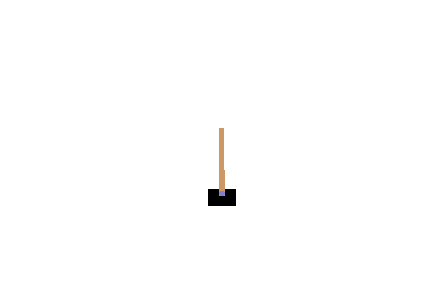
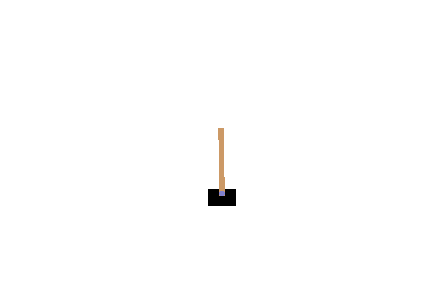
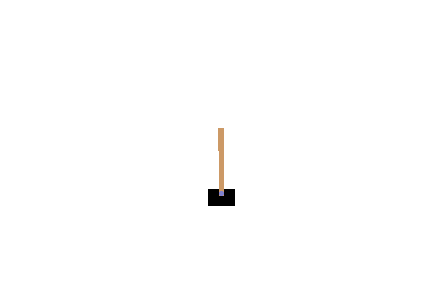
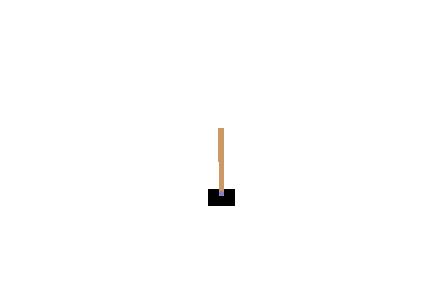
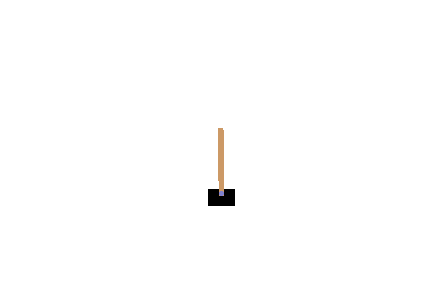
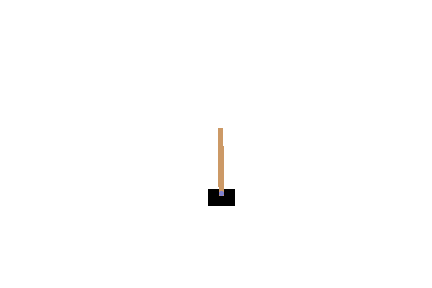
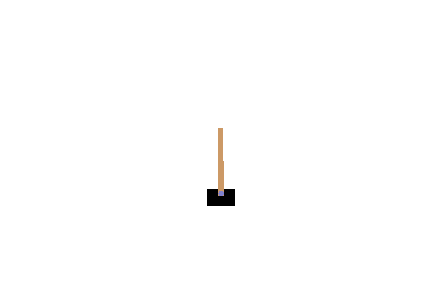
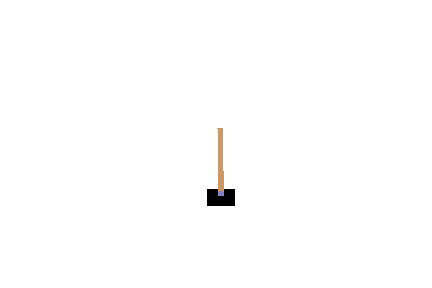
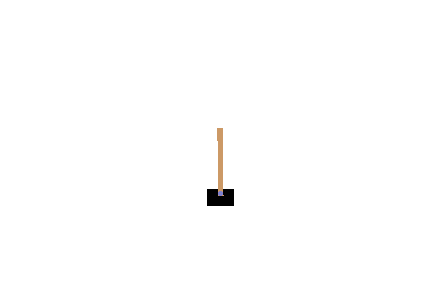
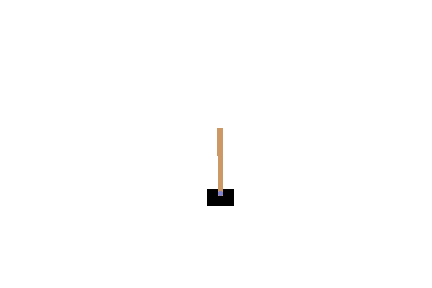
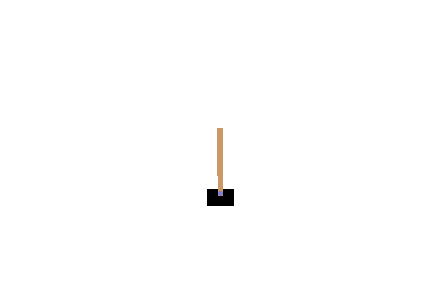
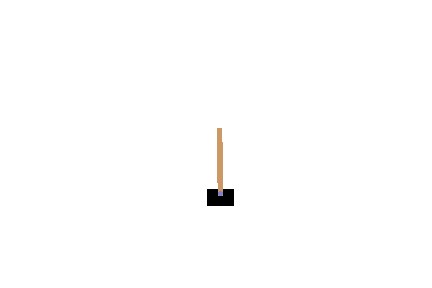
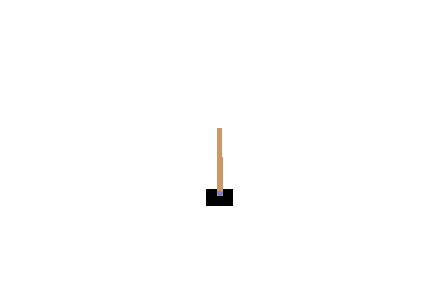
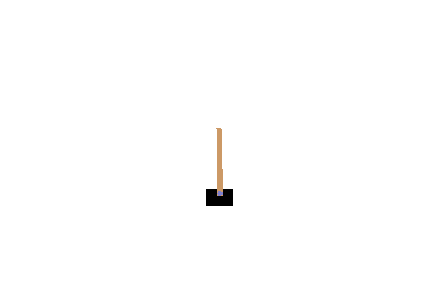
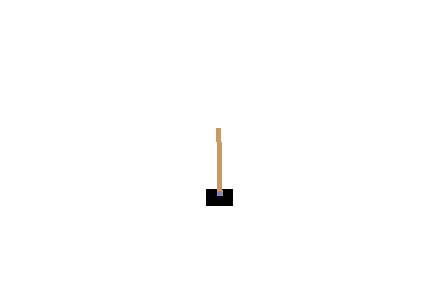
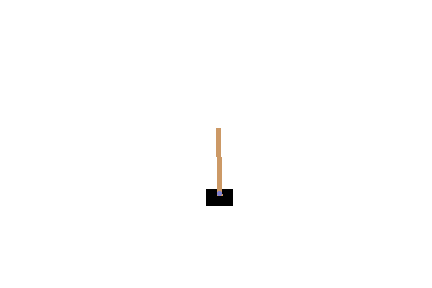
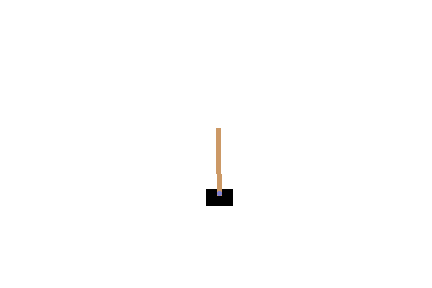
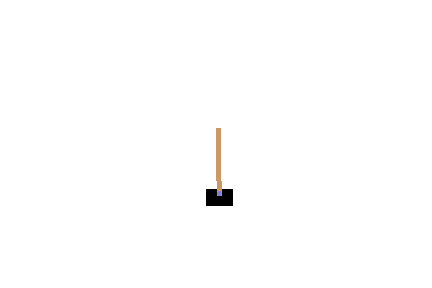
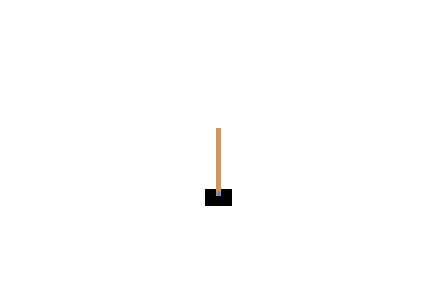
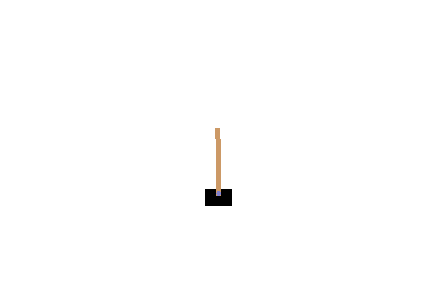
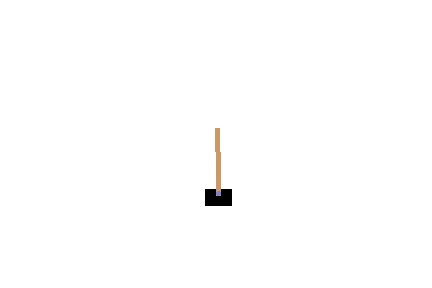
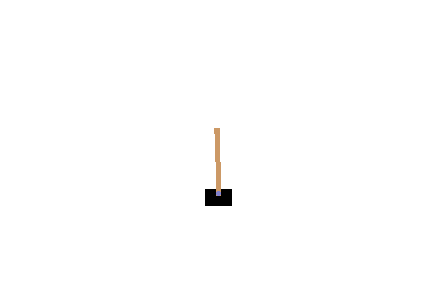
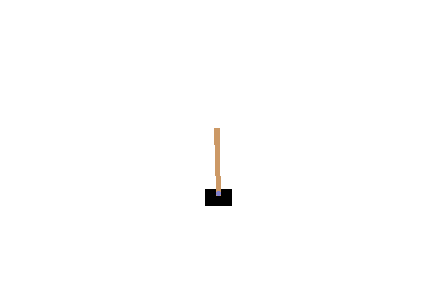
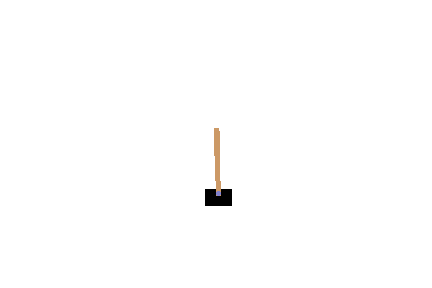
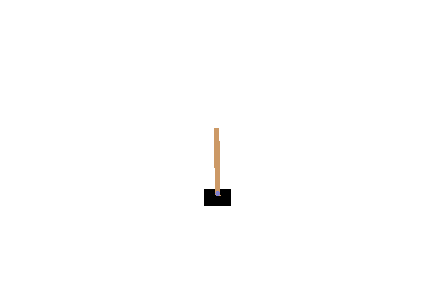
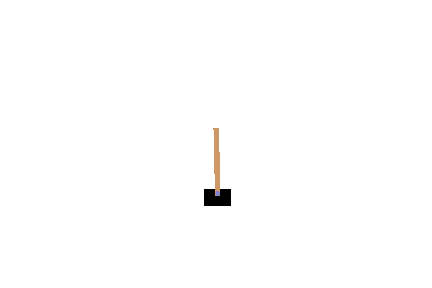
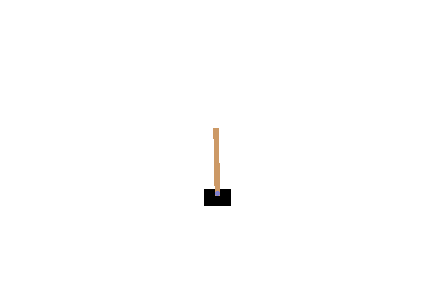
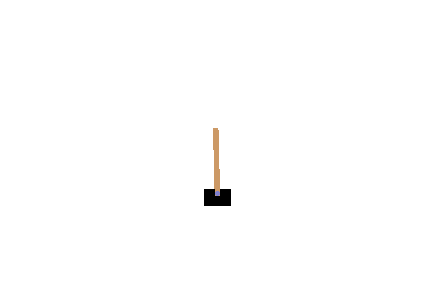
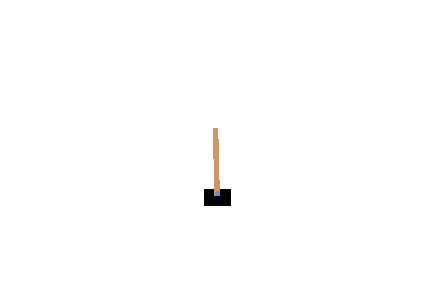
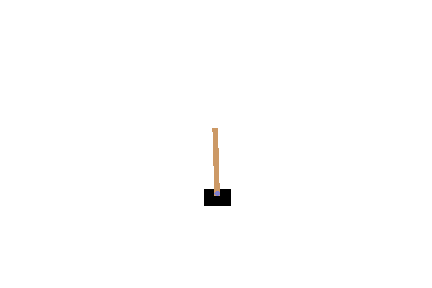
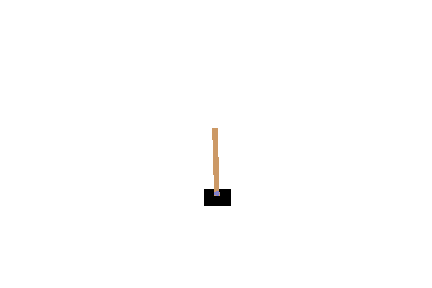
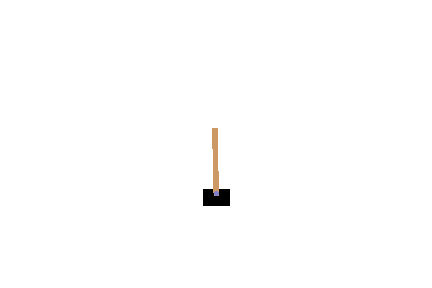
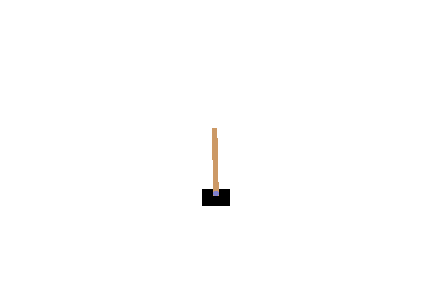
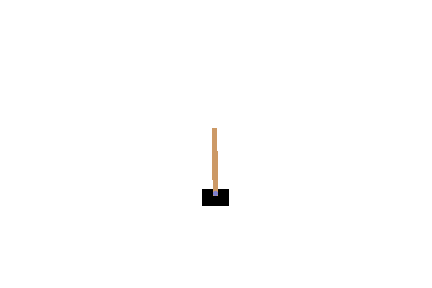
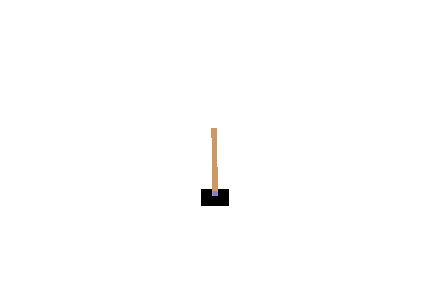
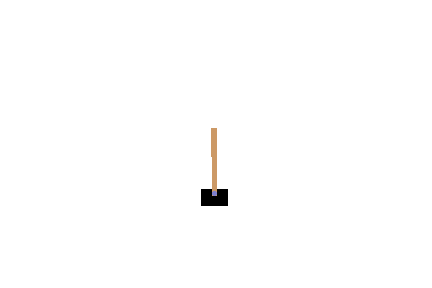
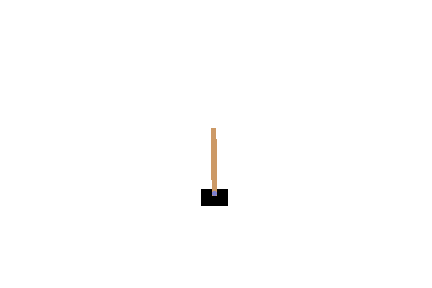
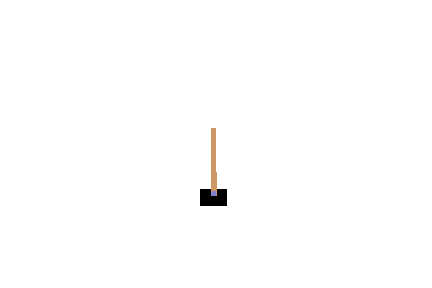
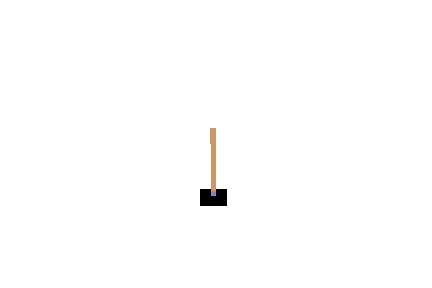
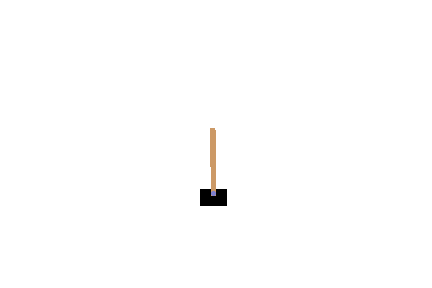
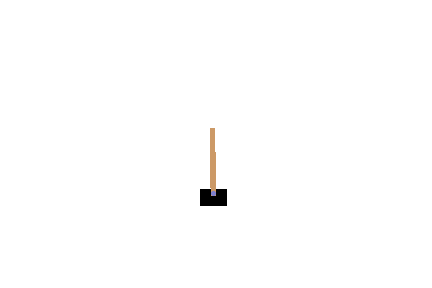
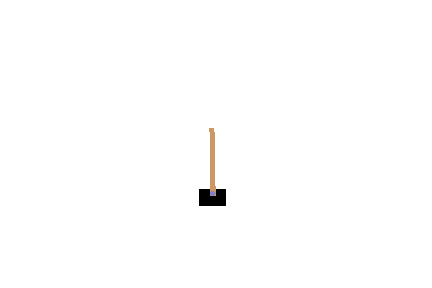
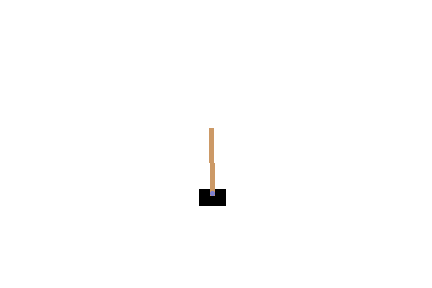
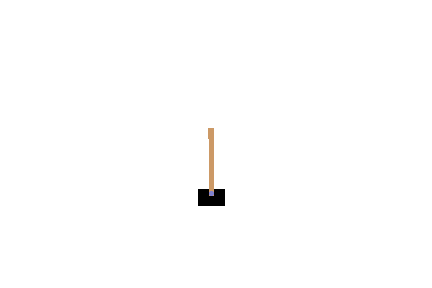
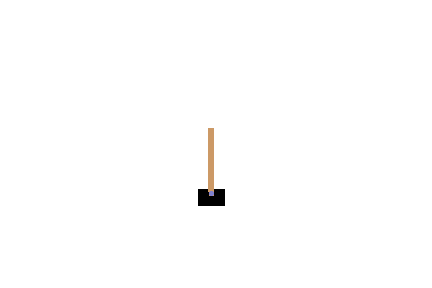
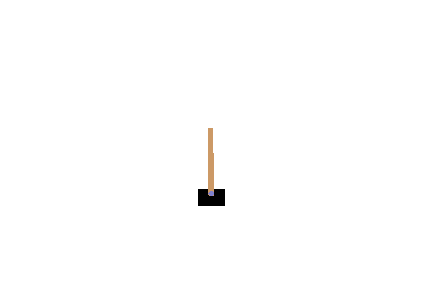
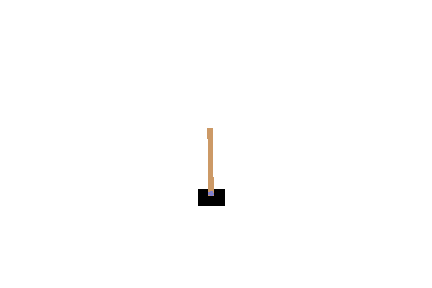
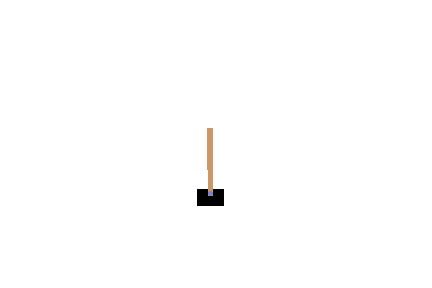
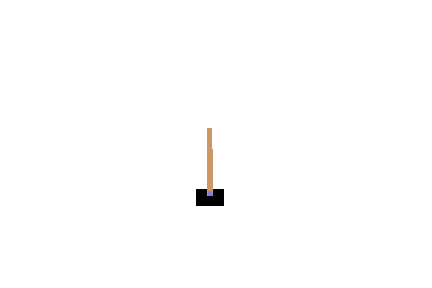
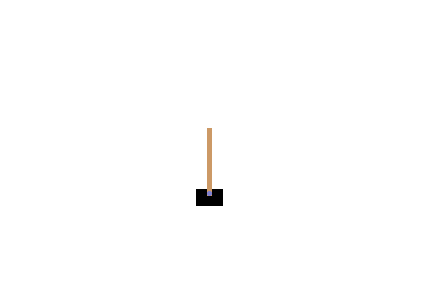
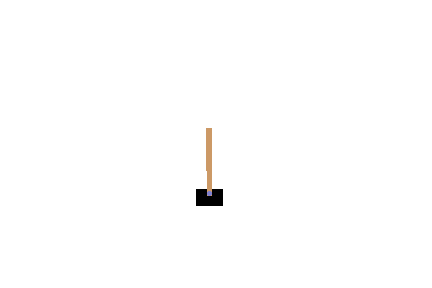
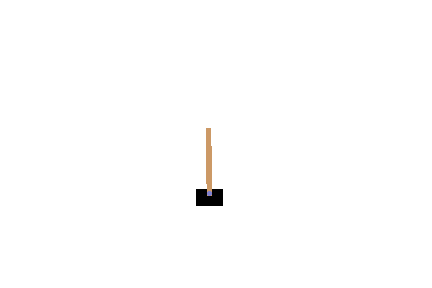
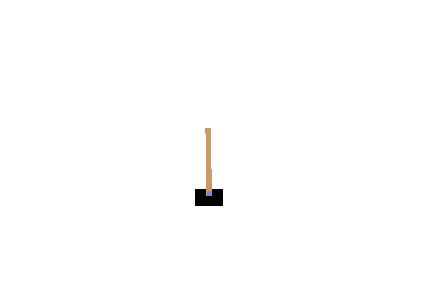
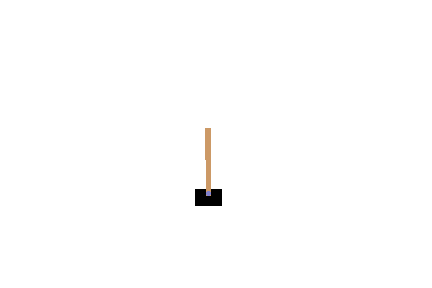
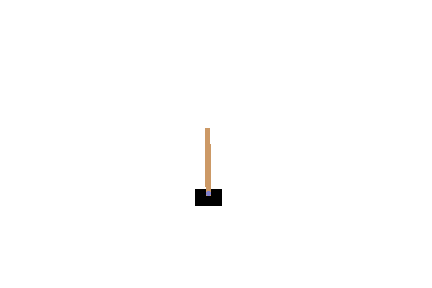
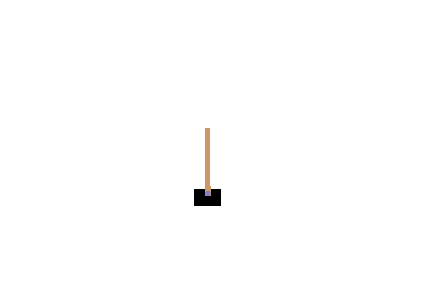
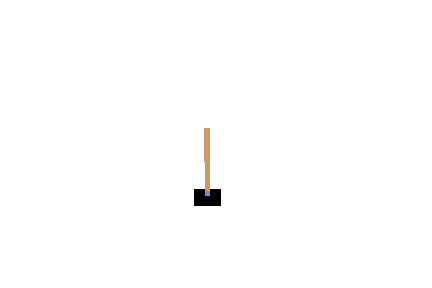
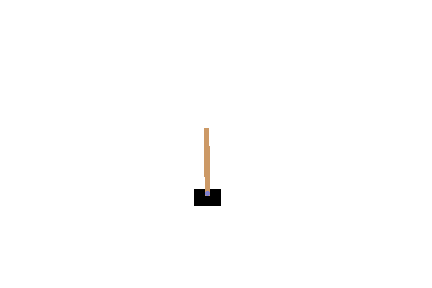
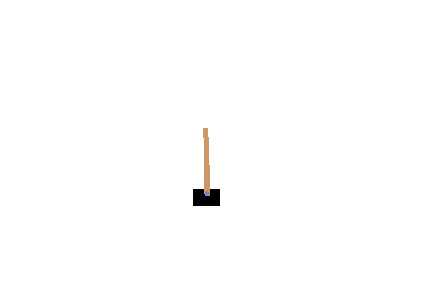
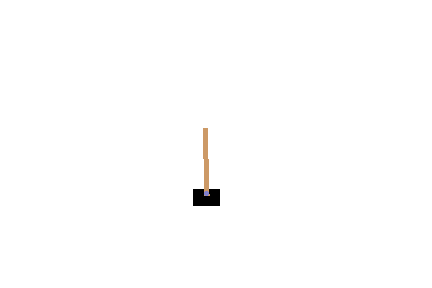
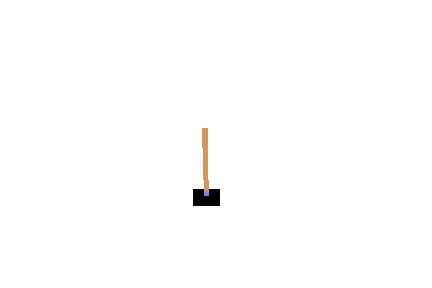
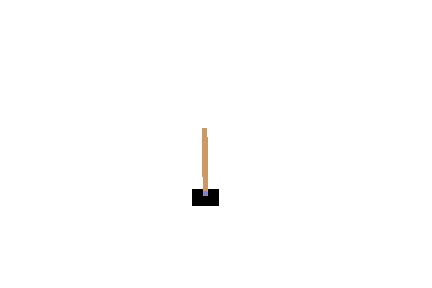
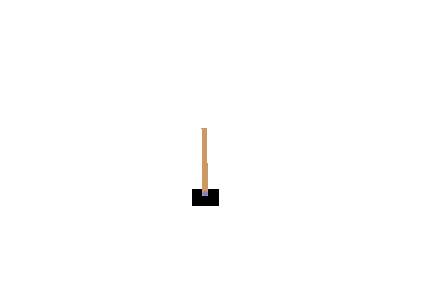
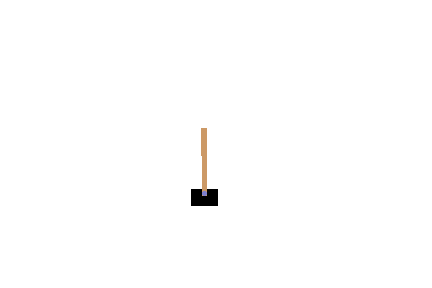
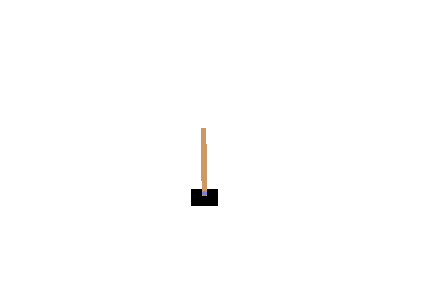
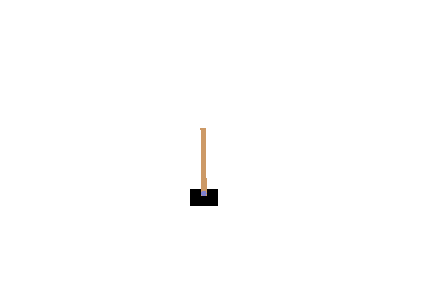
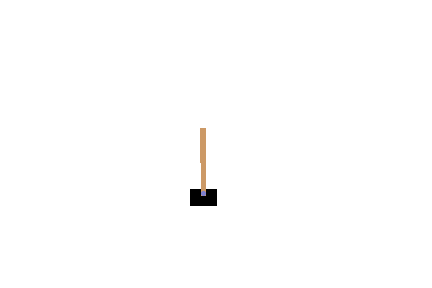
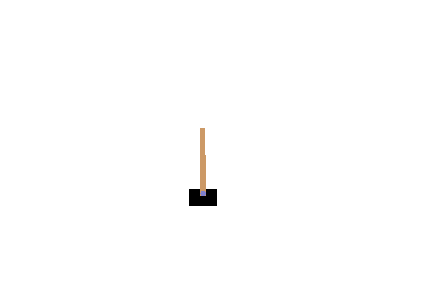
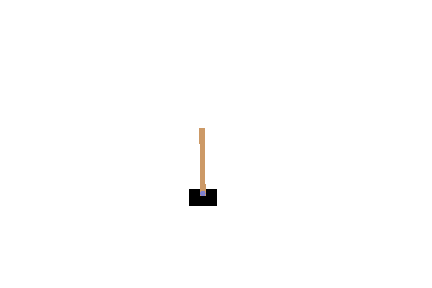
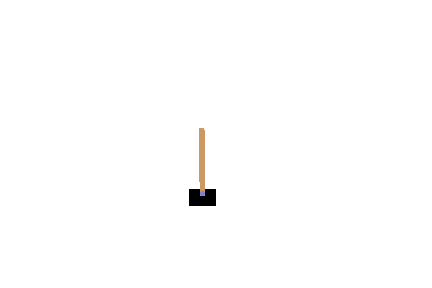
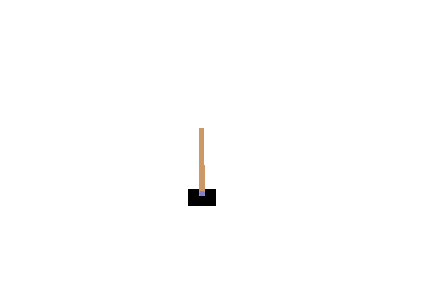
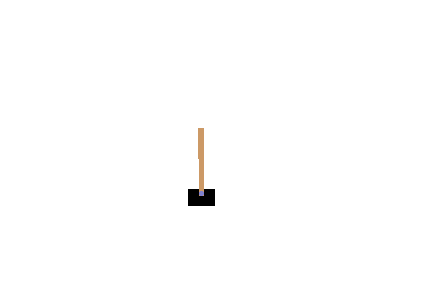
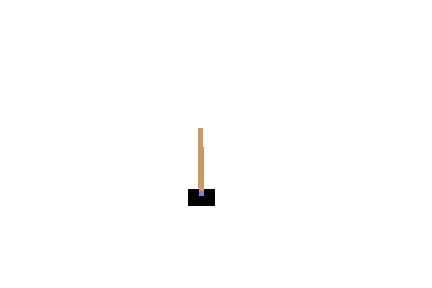
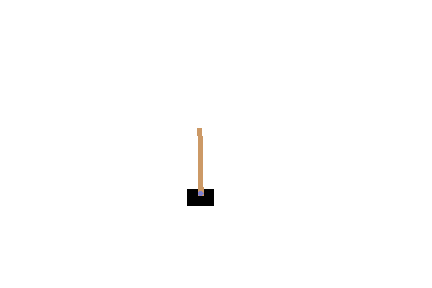
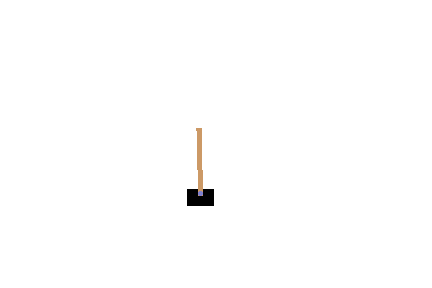
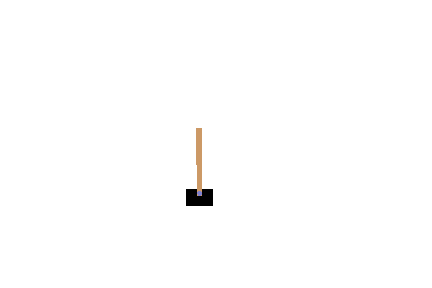
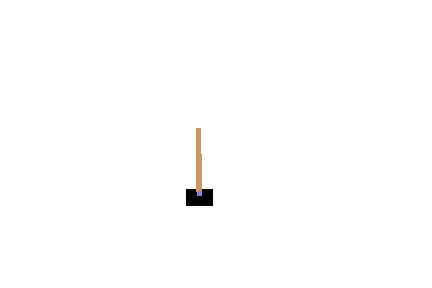
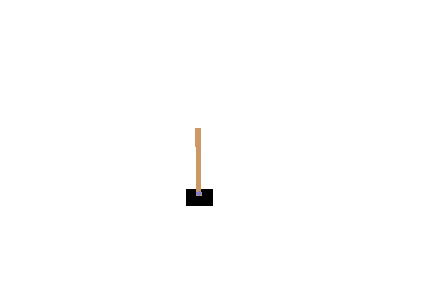
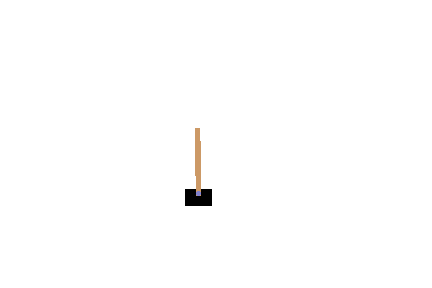
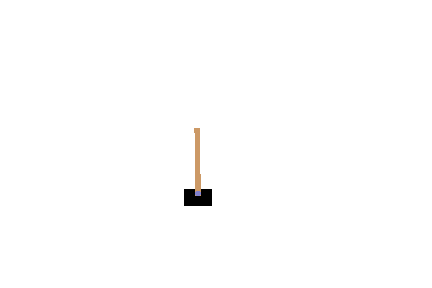
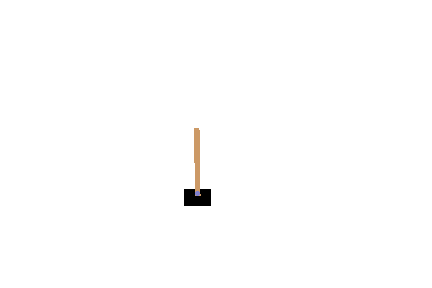
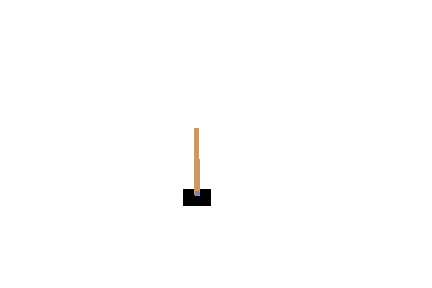
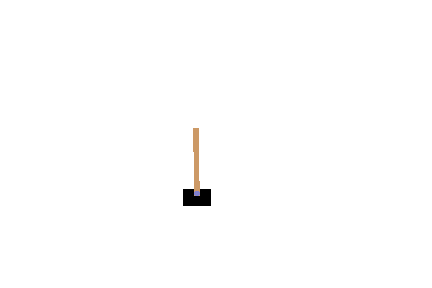
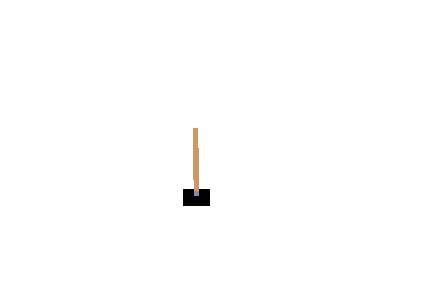
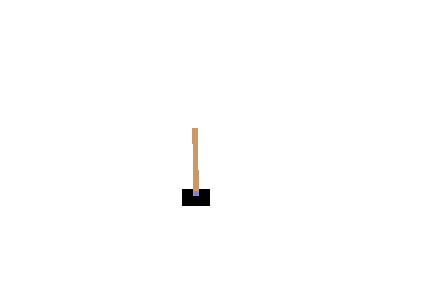
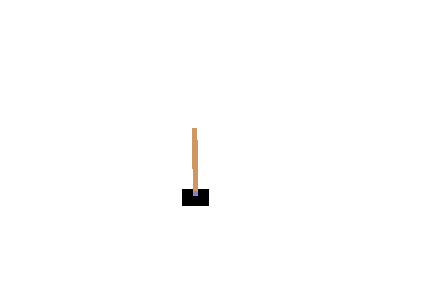
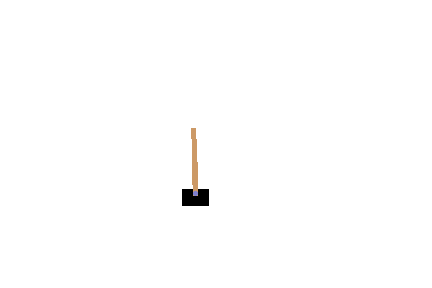
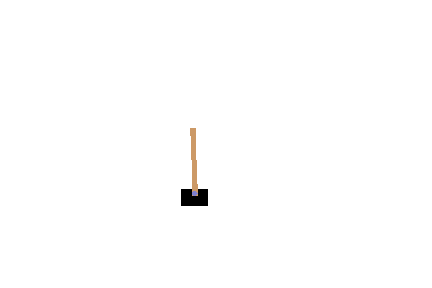
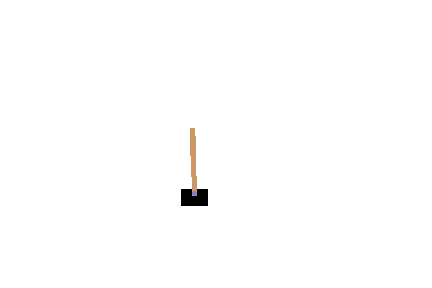
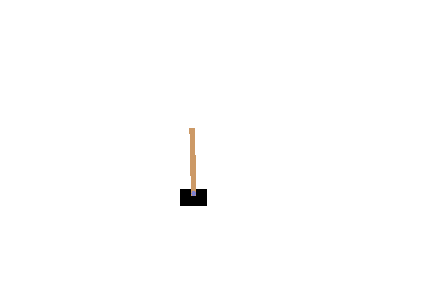
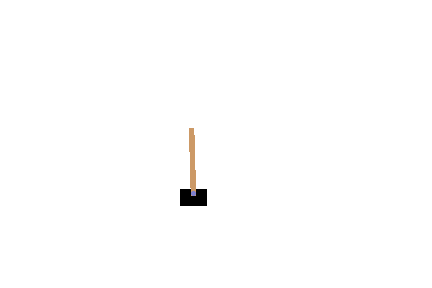
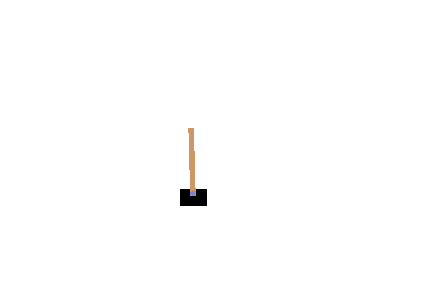
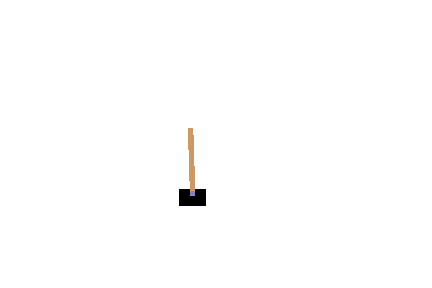
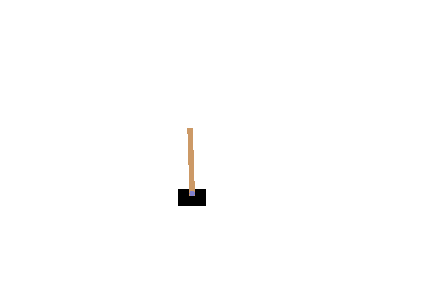
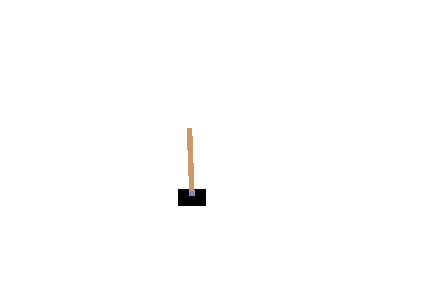
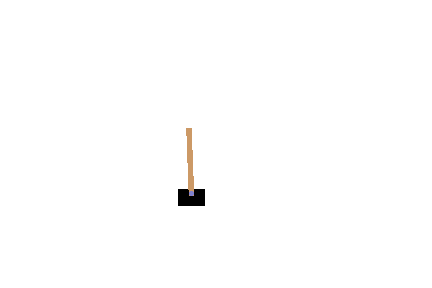
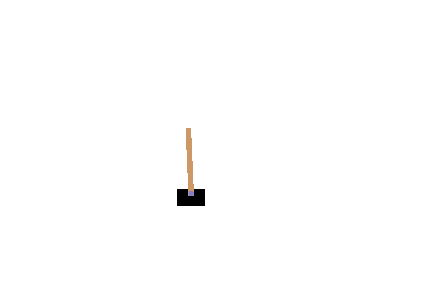
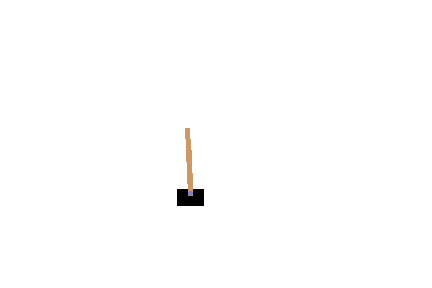
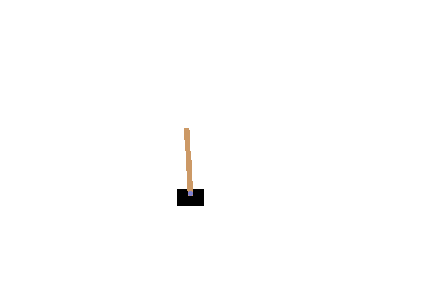
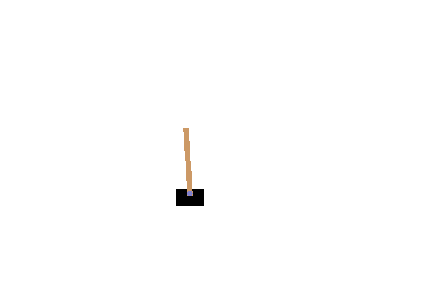
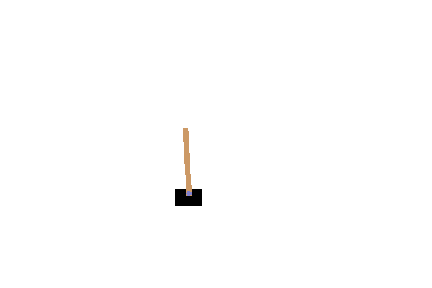
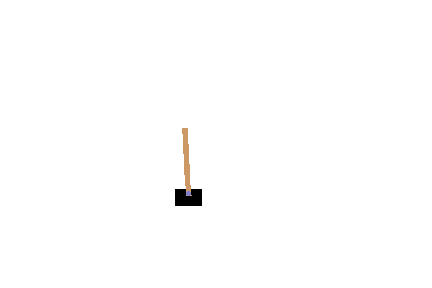
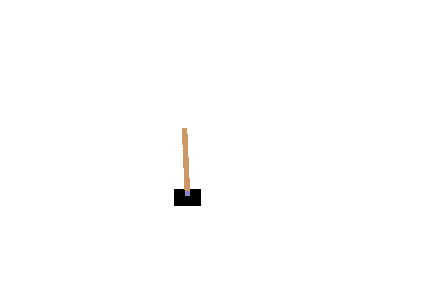
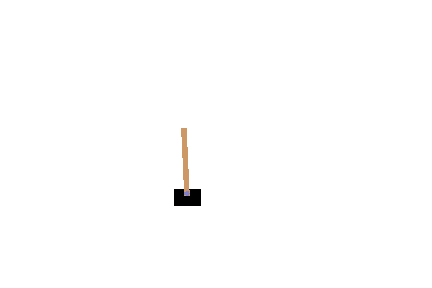
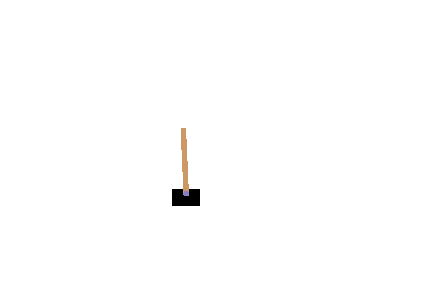
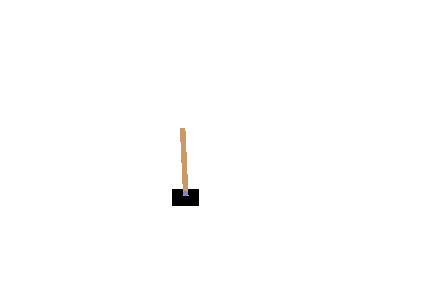
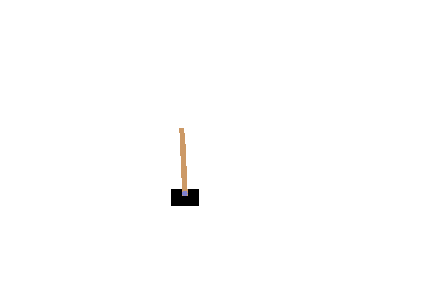
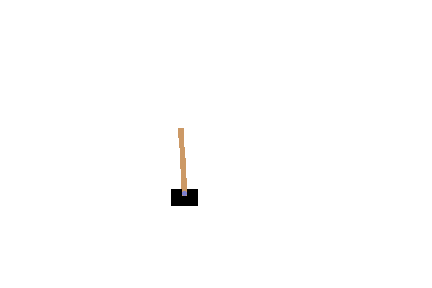
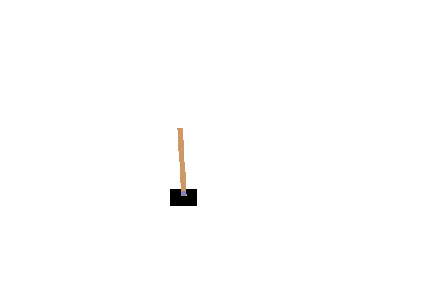
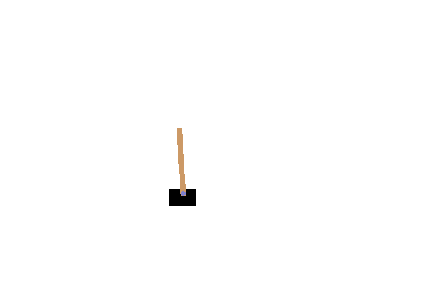
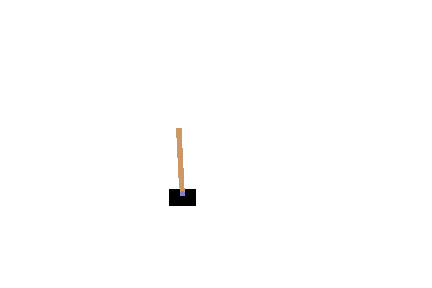
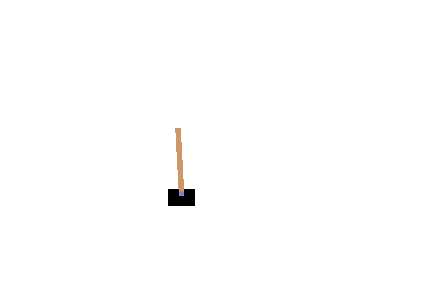
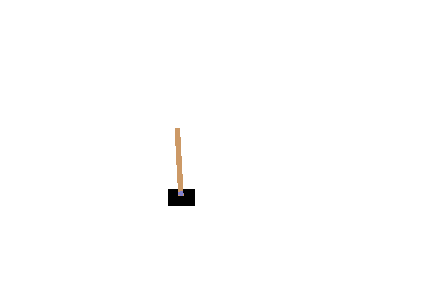
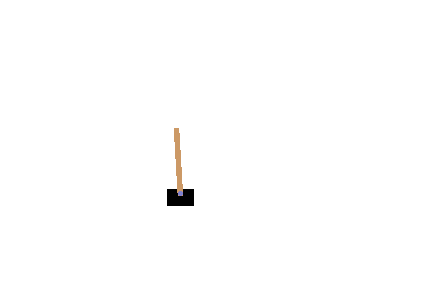
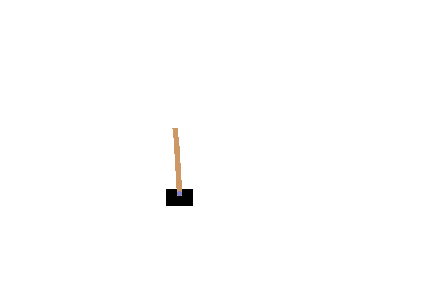
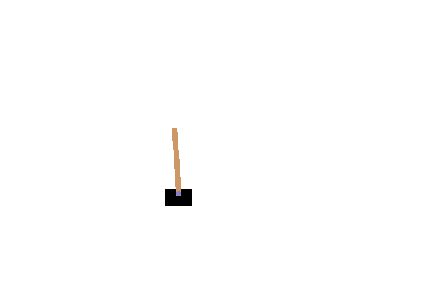
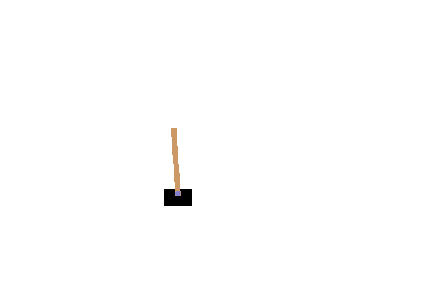
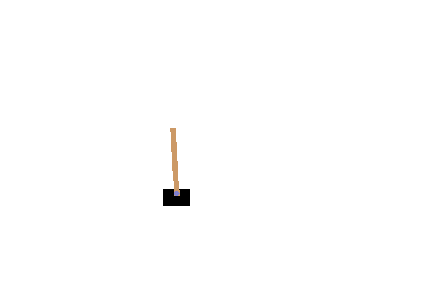
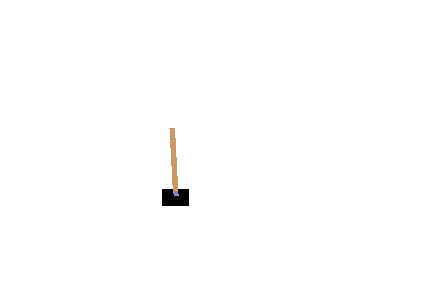
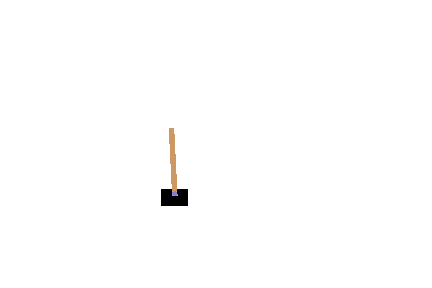
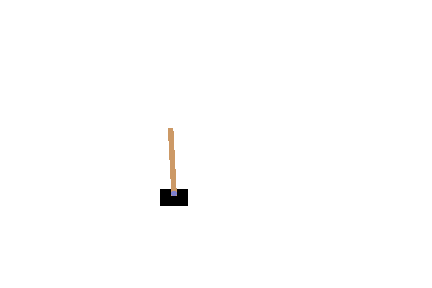
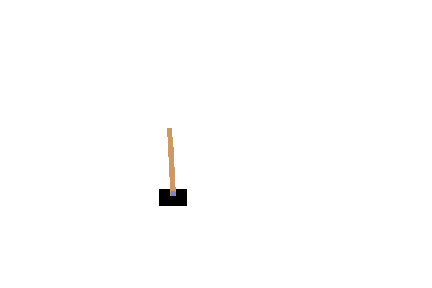
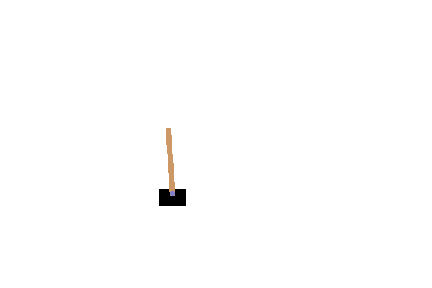
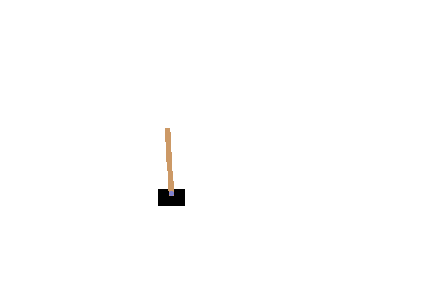
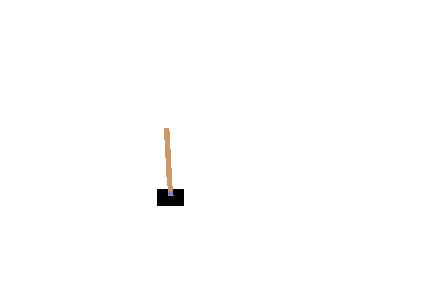
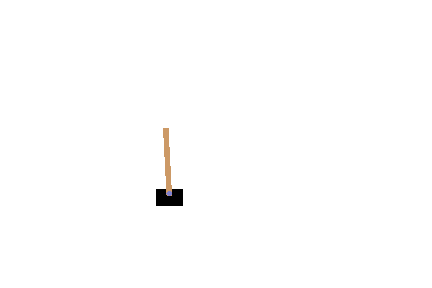
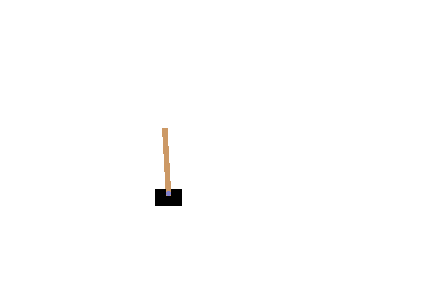
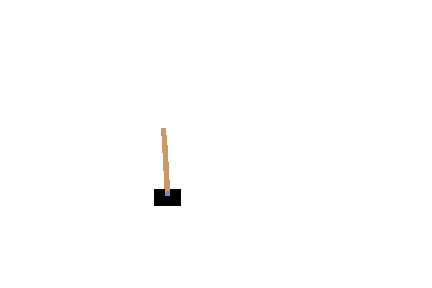
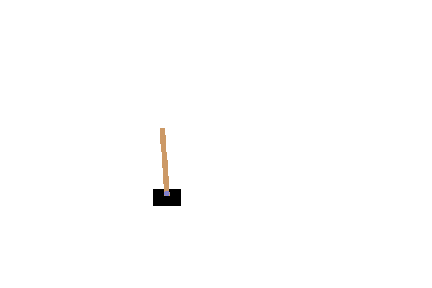
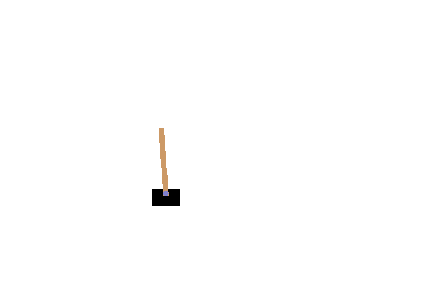
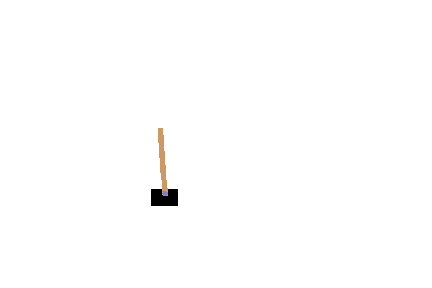
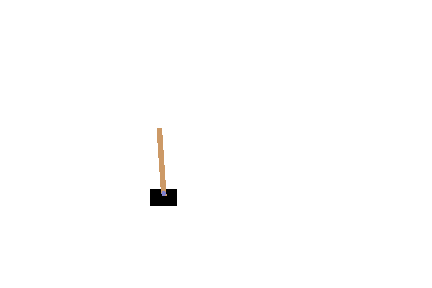
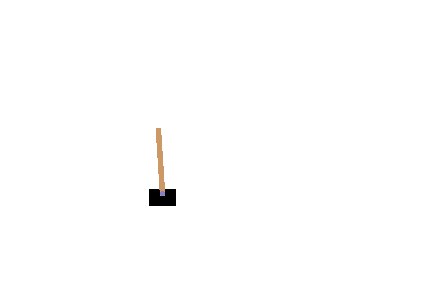
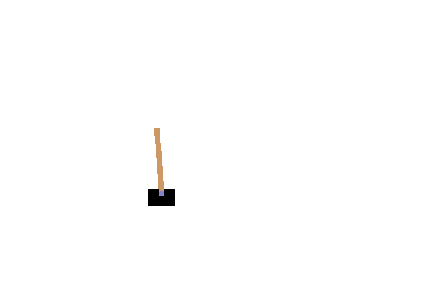
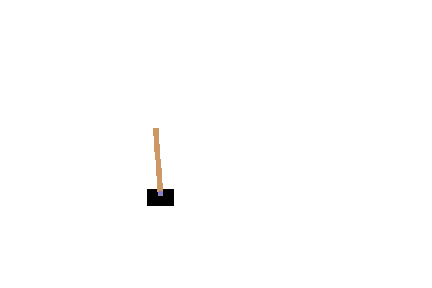
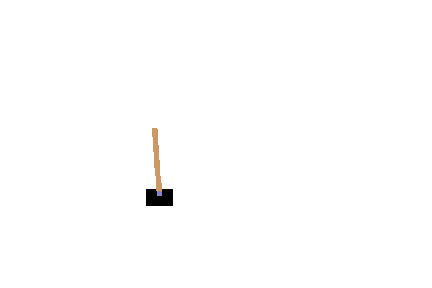
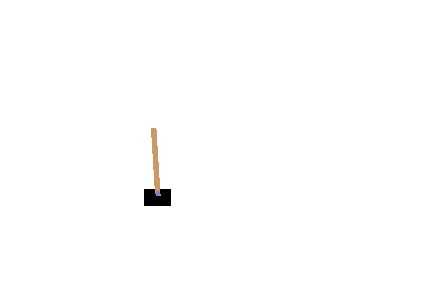
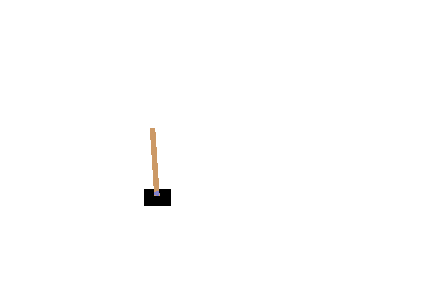
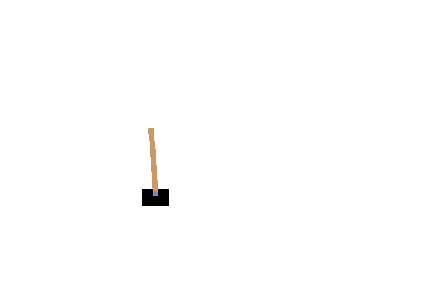
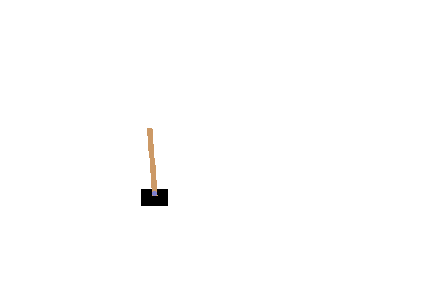
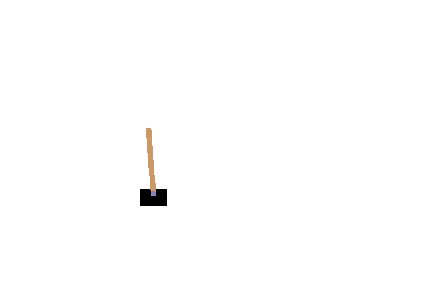
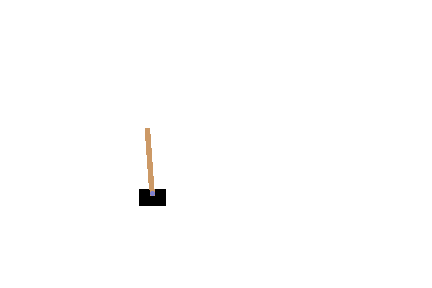
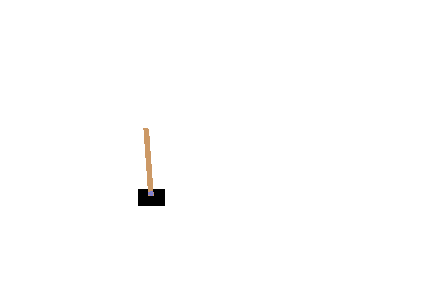
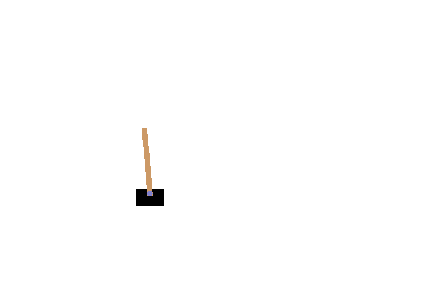
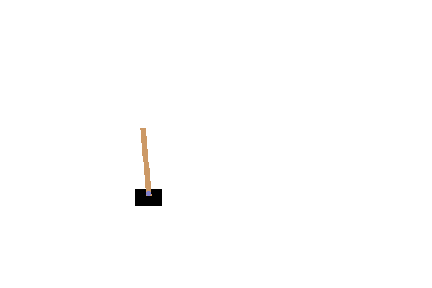
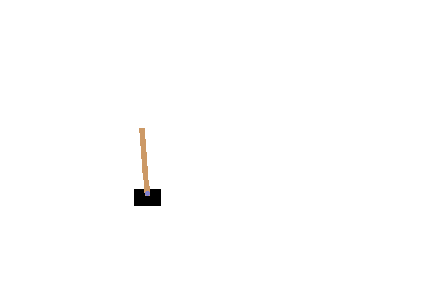
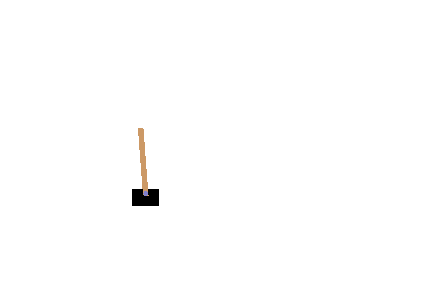
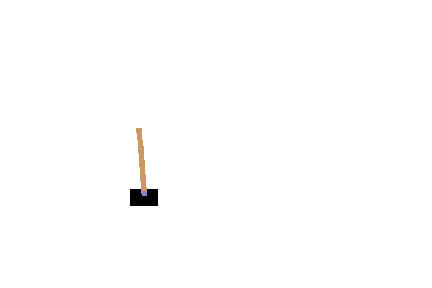
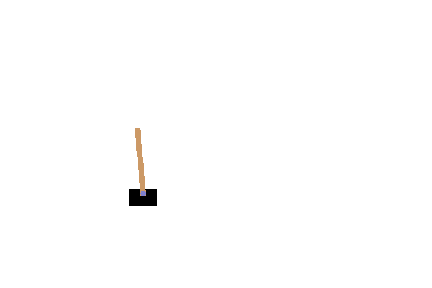
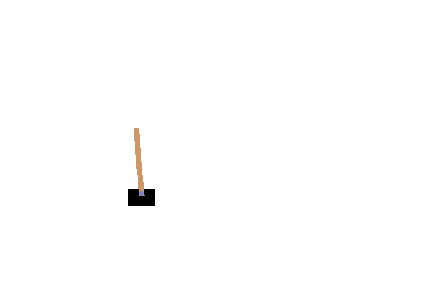
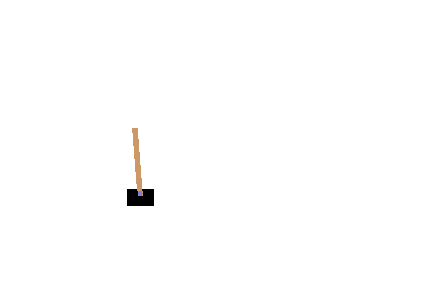
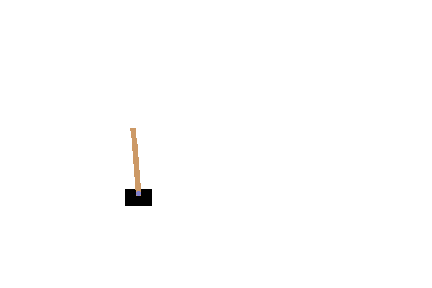
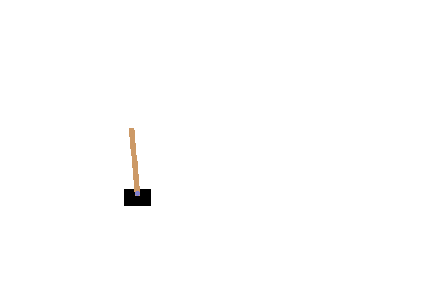
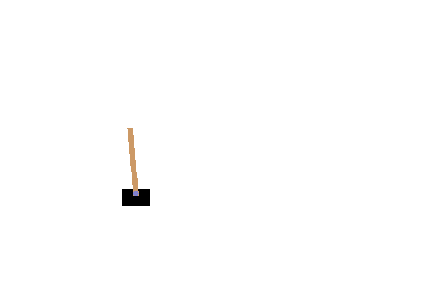
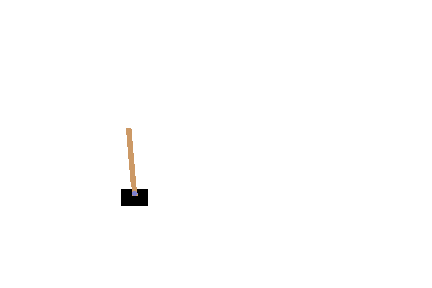
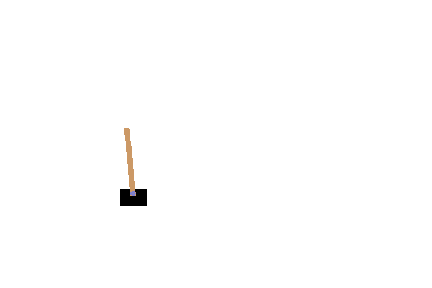

In [64]:
env = gym.make('CartPole-v0')

# Run a demo of the environment
state = agent.preprocess_state(env.reset())
cum_reward = 0
frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.choose_action(state, 0)
    state, reward, done, info = env.step(action)
    state = agent.preprocess_state(state)
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)